# Modules, functions

In [ ]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

In [ ]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

# ----------------------------------------------------------------

def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) # ** The 'type = 2' modification **
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

# ----------------------------------------------------------------

def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS_2(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

# Data

In [ ]:
# ---- adidas ----
rma1_adi = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
                      usecols = ['Article Number', 'Market Retail Price', 'WE eCom', 'eCom Range'])
rma1_adi = rma1_adi[rma1_adi['eCom Range'] == 'YES']

# ---- reebok ----
rma1_rbk = pd.read_csv('data/article_range_rma1_reebok_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
                       usecols = ['Article_number', 'Total Marketing Forecast', '  Total Net Sales  ', '  Total Inline Forecast  ']) # rma1_rbk.columns[40:]



# ----- Buyer reference data (by season) -----
buyer_table = pd.read_csv('data/Buyers Predictions.csv', low_memory = False, error_bad_lines = False, sep = ",")
buyer_table = buyer_table[(buyer_table.season == 'FW19')]

# ----- carryovers -----
carryovers = set(buyer_table.article).intersection(set(rma1_adi['Article Number'])).union(set(buyer_table.article).intersection(set(rma1_rbk.Article_number)))
len(carryovers)




# ----- adidas -----
adi_carryovers = set(buyer_table.article).intersection(set(rma1_adi['Article Number']))
adi_carryovers = pd.DataFrame(data = list(adi_carryovers), columns = ['article_number'])
# adi_carryovers.to_csv("adi_FW20_carryovers.csv", sep=',', encoding='utf-8')

# ----- reebok -----
rbk_carryovers = set(buyer_table.article).intersection(set(rma1_rbk.Article_number))
rbk_carryovers = pd.DataFrame(data = list(rbk_carryovers), columns = ['article_number'])
# rbk_carryovers.to_csv("rbk_FW20_carryovers.csv", sep=',', encoding='utf-8')




In [ ]:
# rma1_adi = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",")
                       
# rma1_adi[rma1_adi['Article Number'].isin(missings)]
                       
                       

In [ ]:
dat0 = pd.read_csv('data/ch4k_df.csv')
ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                  'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc',
                                  'brand_desc', 'bus_unit_desc', 'rmh_cat_desc'])

In [ ]:
# --- adi forecasts ---
WE_eCom = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
                       usecols = ['Article Number', 'WE eCom', 'eCom Range'])
WE_eCom = WE_eCom[WE_eCom['eCom Range'] == 'YES'].drop('eCom Range', axis = 1)

WE_eCom['WE eCom'] = [int(x.replace(",", "")) for x in WE_eCom['WE eCom']]

# --- Reebok forecasts ---
rma1_rbk = (pd.read_csv('data/article_range_rma1_reebok_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
                       usecols = ['Article_number', 'Total Marketing Forecast']).
            rename(columns = {'Article_number': 'Article Number', 'Total Marketing Forecast': 'WE eCom'}))

WE_eCom = pd.concat([WE_eCom, rma1_rbk])

## Investigate Missings, Impact

In [ ]:
# Carryovers articles based on RMA1_lists & buyer_reference_data
carryovers1 = pd.DataFrame(data = list(carryovers), columns = ['article_number'])

# MVP2 *FORECASTED* articles
carryovers2 = pd.read_csv('FW20_mvp2_forecasts.csv', low_memory = False, error_bad_lines = False, sep = ",")

# In reference info but no transactions
missings = carryovers1[~carryovers1.article_number.isin(carryovers2.article_number)]
    # missings[missings.article_number.isin(dat0.article_number)] # ZERO IN TRANSACTION DATA
    # missings.to_csv("missings.csv", sep=',', encoding='utf-8')

In [ ]:
len(carryovers1) # RMA1 and buyer reference
len(carryovers2) # FORECASTED 
len(missings) 

# *** ADD BRAND ***

In [ ]:
missing_ref = ref_dat0[ref_dat0.article_no.isin(missings.article_number)]
# missing_ref.to_csv("missings_ref.csv", sep=',', encoding='utf-8')

missing_ref.head()
missing_ref.shape

In [ ]:
rma1_rbk[rma1_rbk['Article Number'].isin(missings.article_number)] # Reebok

rma1_adi = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",")

rma1_adi_missings = rma1_adi[rma1_adi['Article Number'].isin(missings.article_number)]
rma1_adi_missings.shape
# rma1_adi_missings

rma1_adi_missings['Market Retail Intro Date'].unique()

rma1_adi_missings.loc[:,'WE eCom'] = [int(x.replace(",", "")) for x in rma1_adi_missings['WE eCom']]

In [ ]:
rma1_adi_missings.loc[:,'rev'] = rma1_adi_missings['GTM Target Retail Price EUR']*rma1_adi_missings['WE eCom']
rma1_adi_missings.rev.sum()

In [ ]:
buyer_table = pd.read_csv('data/Buyers Predictions.csv', low_memory = False, error_bad_lines = False, sep = ",")

In [ ]:
buyer_table[buyer_table.article.isin(missings.article_number)].set_index(['article', 'season'])

In [ ]:
# -------------------------------------------------

# GAS

In [ ]:
dat_GAS = dat0.copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'buy_availability']]

dat_GAS = dat_GAS[(dat_GAS.season == 'FW19') & (dat_GAS.article_number.isin(carryovers))].sort_values(['article_number', 'country', 'year', 'week'])

len(dat_GAS.article_number.unique())
dat_GAS.head()

In [ ]:
# dat_GAS_a = np.random.choice(dat_GAS.article_number.unique(), size = 100, replace = False)
# dat_GAS = dat_GAS[dat_GAS.article_number.isin(dat_GAS_a)]

dat_GAS = dat_GAS.groupby(['article_number', 'country']).apply(GAS_est).reset_index()
dat_GAS = pd.DataFrame(dat_GAS.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()

dat_GAS.shape
dat_GAS.head()
len(dat_GAS.article_number.unique())

# Seasonality

In [ ]:
seasonality_dat = (dat0.
    copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 
            'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 
            'age_group_desc', 'franchise', 'prod_grp_desc']].
    dropna().sort_values(['article_number', 'year', 'week'])
                  )

# -- Sum over UK/EU, ADD article reference data --
seasonality_dat = pd.merge(
    pd.DataFrame(seasonality_dat.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum()).reset_index(), # sum over UK & EU
    seasonality_dat[['article_number', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() # add reference information
    ).dropna().sort_values(['article_number', 'year', 'week'])

# -- Reliable, mirror seasons --
seasonality_dat = seasonality_dat[~seasonality_dat.season.isin(['FW14', 'FW15', 'SS14','SS15', 'SS16', 'SS17', 'SS18', 'SS19'])]



In [ ]:
# ---- Calculate cat-level weekly means across *ALL SEASONS* ---- 

seasonality_sport   = pd.DataFrame(seasonality_dat.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
seasonality_rmh     = pd.DataFrame(seasonality_dat.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
seasonality_gndr    = pd.DataFrame(seasonality_dat.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
seasonality_agegrp  = pd.DataFrame(seasonality_dat.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
seasonality_frnchse = pd.DataFrame(seasonality_dat.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
seasonality_prdgrp  = pd.DataFrame(seasonality_dat.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})

seasonality_dfs = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]



In [ ]:
def regress(df):
    # function for regressing article net_qty on seasonalities
    # for article a's level of each category, retreive weekly means, then regress 
    
    df = df.sort_values(['article_number', 'year', 'week'])
        
    # article net_demand_qty
    y = df[['net_qty', 'week']].set_index('week')

    # article category-level weekly means; set_index() for joining
    x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
    x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
    x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
    x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
    x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
    x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

    # design matrix (ensure 'week' alignment)
    yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
          merge(x_rmh, left_index=True, right_index=True, how = 'outer').
          merge(x_gndr, left_index=True, right_index=True, how = 'outer').
          merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
          merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
          merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
          drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
               'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

    # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities

    y = yX.net_qty
    
    X = yX.drop('net_qty', axis = 1)
    # X = sm.add_constant(X) # ****** ******* *******
    
    mod = sm.OLS(y, X, missing='drop').fit()
    # print(df.article_number.unique(), round(mod.rsquared, 2))

    ret = pd.DataFrame(index = X.index)
    ret['seas_preds'] = mod.predict(X).round()
    
    ret = ret.reset_index()
    ret = pd.DataFrame(ret.groupby('week')['seas_preds'].mean())

    return ret

In [ ]:
seasonality_dat = seasonality_dat[(seasonality_dat.article_number.isin(carryovers))].sort_values(['article_number', 'year', 'week']) 

len(seasonality_dat.article_number.unique()) # 886 (from 952 + 90 before)

# ----- Subset for development -----
# a = np.random.choice(seasonality_dat.article_number.unique(), size = 3, replace = False)
# seasonality_dat = seasonality_dat[seasonality_dat.article_number.isin(dat_GAS_a)].copy()



In [ ]:
# regress articles of interest on seasonality
preds = seasonality_dat.groupby(['article_number']).apply(regress).reset_index()


In [ ]:
# Merge back with reference data
preds = pd.merge(
    preds,
    seasonality_dat[seasonality_dat.season == 'FW19'],
    how = 'left').sort_values(['article_number', 'year', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']] # .fillna(method='ffill')

# Zero out negative preds
preds['seas_preds'] = np.where(preds.seas_preds > 0, preds.seas_preds, 0) 

# Combined observed weeks (partial season)  --- AND --- regression predicted (all) weeks
preds = pd.merge(
    preds,   # all weeks
    dat_GAS, # observed weeks
    how = 'left')


# EDA Plots

In [ ]:
preds_season = preds_season.reset_index()

,net_qty,GAS_est,seas_preds
week,,,
22,33.0,117.0,0.0
23,227.0,108.0,199.0
24,87.0,256.0,110.0
25,95.0,257.0,218.0
26,100.0,265.0,192.0
27,90.0,300.0,60.0
28,58.0,335.0,107.0
29,61.0,325.0,32.0
30,63.0,276.0,17.0


GAS_est       6974.0
net_qty       3820.0
seas_preds    8161.0
dtype: float64

,article_number,brand,model_no,description,type,BU,RMH,price,cost,margin,net_forecast,buy_recommendation,eCom_RMA1,impact,FW19_total_ecom_SO,FW19_total_market_FC,FW19_total_ecom_RDP,notes
148,DV1549,ADIDAS,FUD20,3-STRIPES PANT,TRACKSUIT PANTS,BU ORIGINALS APP/ACC,ORIGINALS,48,8,41,10825,13476,9535,63210,4138,9000,10588,-


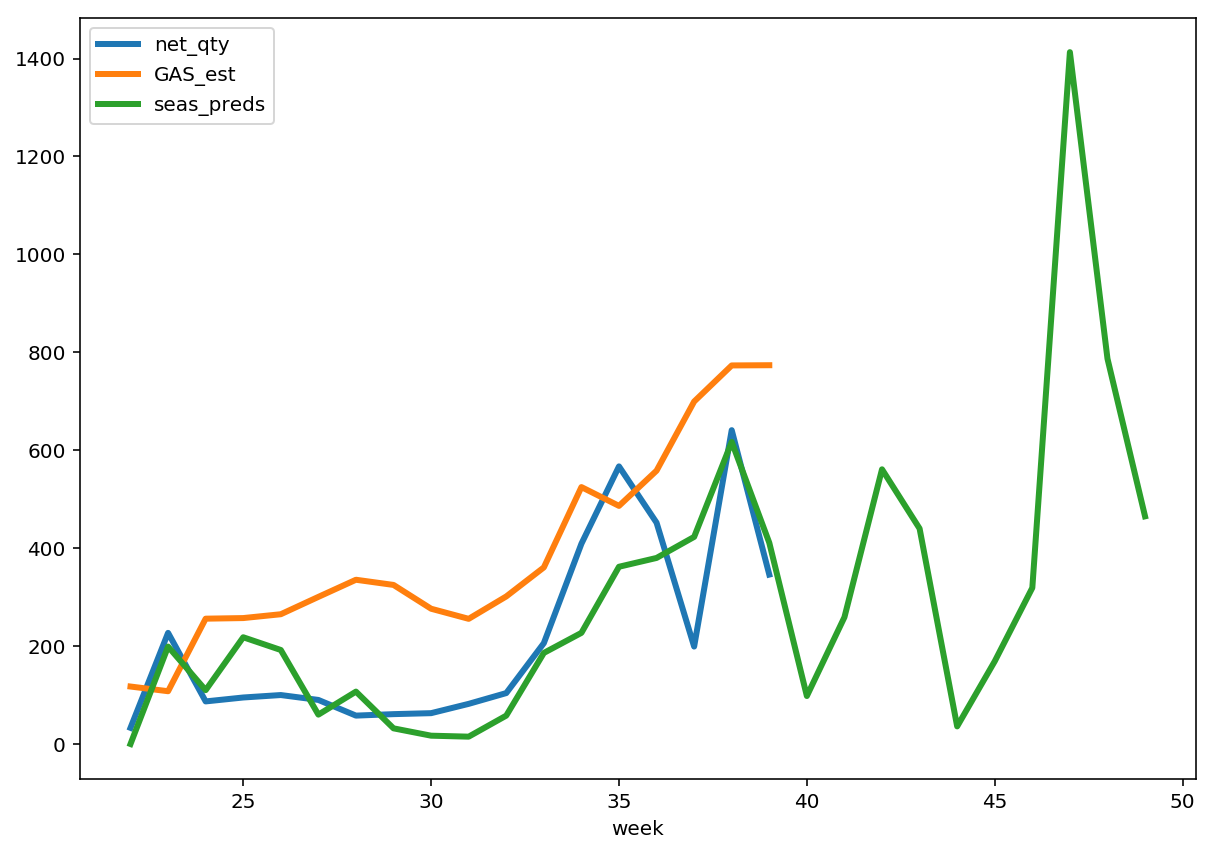

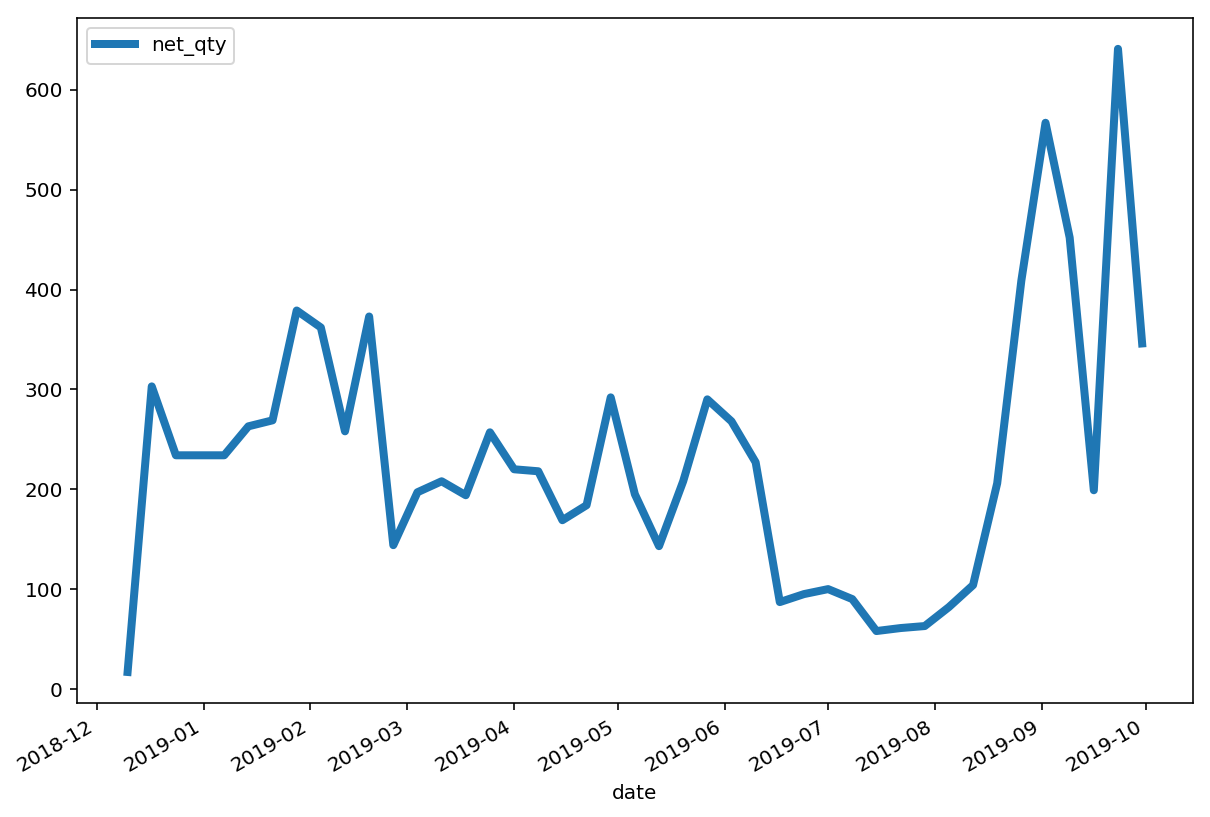

In [126]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'DV1549'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
        
plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# dat_aoi

# April articles

In [162]:
aas = ['DV1549', 'EE1152', 'DV1508', 'ED6024', 'CY4574', 'ED9384', 'BK7345', 'DV2400', 'DH5798']

# aoi = 'DV1549'
# a = aoi

preds_aa = (preds[preds.article_number.isin(aas)][['article_number', 'week', 'net_qty', 'GAS_est', 'seas_preds']].
            sort_values(['article_number', 'week']).
            set_index('week'))
        

In [163]:
preds_aa.head()

,article_number,net_qty,GAS_est,seas_preds
week,,,,
22,BK7345,11.0,156.189086,41.0
23,BK7345,241.0,243.319358,222.0
24,BK7345,323.0,324.317032,211.0
25,BK7345,405.0,265.243919,295.0
26,BK7345,722.0,455.291134,236.0


In [ ]:
plt.rcParams["figure.figsize"] = [10,7]

for a in aas:
    print(a)
    preds_aa[preds_aa.article_number == a].plot(linewidth = 3)
    
# preds_aa.sort_values(['article_number', 'week']).set_index('week').round()



Text(0.5, 1.0, 'DV1549')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'EE1152')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'DV1508')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'ED6024')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'CY4574')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'ED9384')

No handles with labels found to put in legend.


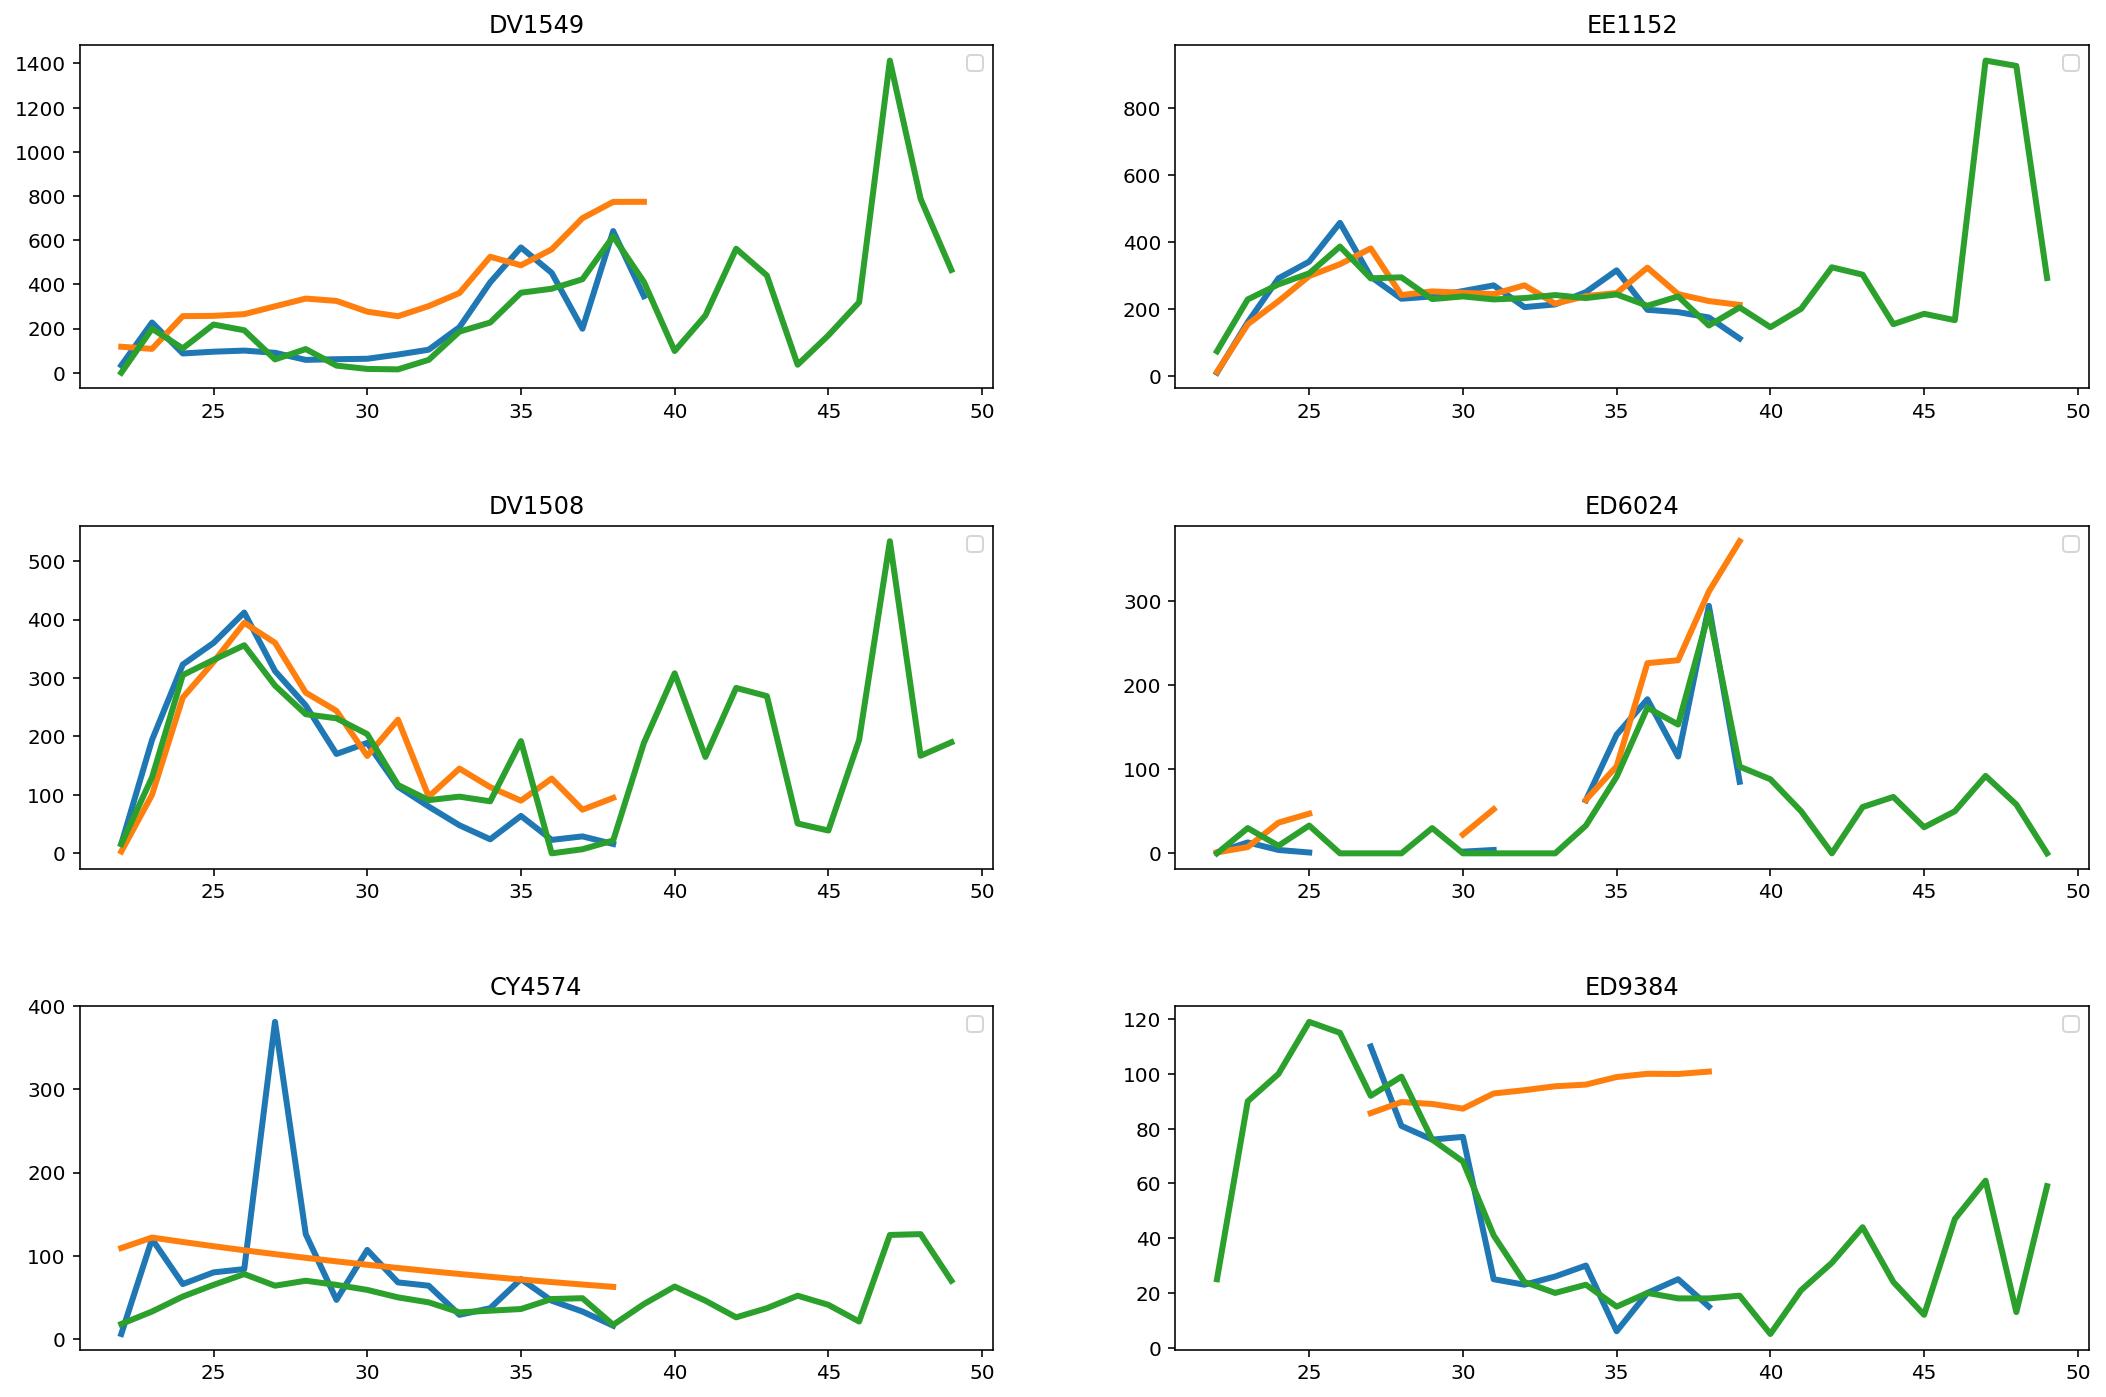

In [203]:

fig = plt.figure(figsize=(18,12)) # width, height
fig.subplots_adjust(hspace=0.4, wspace=0.2) # vertical spacing, horizontal spacing
for i in range(1, 7):
    ax = fig.add_subplot(3, 2, i, )
    preds_ax = preds_aa[preds_aa.article_number == aas[i-1]]
    ax.plot(preds_ax.index, preds_ax[['net_qty', 'GAS_est', 'seas_preds']], linewidth=3)
    ax.set_title(aas[i-1])
    ax.legend()
    

In [ ]:
preds_aa[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index.isin(aas)]

dat_aa = dat0[dat0.article_number.isin(aas)].copy()

dat_aa = pd.merge(
    pd.DataFrame(dat_aa.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aa[['year', 'week']].drop_duplicates()
)

dat_aa.year = [str(x) for x in dat_aa.year]
dat_aa.week = [str(x) for x in dat_aa.week]
dat_aa['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aa.year, dat_aa.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aa[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# Product Lifecycle 

In [ ]:
dat_lifespan = dat0.copy()

# Just article & season
dat_lifespan = dat_lifespan[['article_number', 'season']].drop_duplicates()

# Lifespan
dat_lifespan = pd.DataFrame(dat_lifespan.article_number.value_counts()).reset_index().rename(columns = {'index': 'article', 'article_number': 'lifespan'})

# net_qty per season
dat_lifespan2 = pd.DataFrame(dat0.groupby(['article_number', 'season'])['net_qty'].apply(sum)).reset_index()

# Combine
dat_lifespan = pd.merge(
    dat_lifespan2,
    dat_lifespan,
    how = 'left', left_on= 'article_number', right_on = 'article'
).drop('article', axis = 1)

# --- For sorting ---
key = {'SS14': 1, 'FW14': 2, 'SS15': 3, 'FW15': 4, 
       'SS16': 5, 'FW16': 6, 'SS17': 7, 'FW17': 8, 
       'SS18': 9, 'FW18': 10, 'SS19': 11, 'FW19': 12}
dat_lifespan['order_key'] = [key[s] for s in dat_lifespan.season]

dat_lifespan = dat_lifespan.sort_values(['article_number', 'order_key'])

dat_lifespan.drop

In [ ]:
def lifecycle_season_assign(df):
    df = df.sort_values('order_key')

    ret = pd.DataFrame()
    ret['season'] = df.season
    ret['lifecycle_season'] = list(range(1, df.shape[0] + 1))

    return ret

In [ ]:
lifecycle = dat_lifespan.groupby('article_number').apply(lifecycle_season_assign).reset_index().drop('level_1', axis = 1)

dat_lifecycle = pd.merge(
    dat_lifespan,
    lifecycle
)


In [ ]:
dat_lifecycle

In [ ]:
dat_lifecycle_medians = pd.DataFrame(dat_lifecycle.groupby(['lifespan', 'lifecycle_season'])['net_qty'].mean()).reset_index()

dat_lifecycle_medians = dat_lifecycle_medians[~dat_lifecycle_medians.lifespan.isin([1, 12])]

In [ ]:
dat_lifecycle_medians

In [ ]:
t = dat_lifecycle_medians.copy()

In [ ]:
plt.figure(figsize=(16, 8))
sns.lineplot(x = t.lifecycle_season, y = t.net_qty, hue= t.lifespan, palette="tab10", linewidth=4).set_title('Means by Age, for Life-length Groups')

# set_index(['lifespan', 'lifecycle_season'])



In [ ]:
sns.palplot(sns.color_palette())


# Aggregate to Season

In [109]:
# weekly assignment of GAS, seasonality, or combination
preds['y_hat'] = np.where(np.isnan(preds.GAS_est), preds.seas_preds, (preds.GAS_est + preds.seas_preds)/2)

# Sum over season
preds_season = pd.DataFrame(preds.groupby('article_number')['y_hat'].apply(sum).round())

preds_season['y_hat'] = preds_season.y_hat * 1.1 # default growth rate

# Combine DAA + eCom
preds_season = pd.merge(
    preds_season.reset_index(),             # DAA forecasts
    WE_eCom[['Article Number', 'WE eCom']], # eCom RMA1 forecast
    how = 'left', left_on='article_number', right_on='Article Number'
).drop('Article Number', axis = 1).round()

# Overbuy

In [ ]:
from functools import partial
from scipy import optimize
from scipy import integrate
import scipy.stats as stats

# Loss --- demand, buy, margin, cost
def L(d, b, margin, cost):
    if d > b:
        return (d - b)*margin
    elif d < b:
        return (b - d)*cost
    elif d == b:
        return 0
    else:
        print('Error')

# E[L | buy, article_mean, article_sd, article_margin, article_cost]
def EL(mu, sigma, margin, cost, b):
    I = lambda x: L(x, b, margin, cost) * stats.norm.pdf(x, mu, sigma) # I for integrand
    Exp_loss = integrate.quad(I, 0, mu + 3*sigma)/(1 - stats.norm.cdf(0, loc = mu, scale = sigma)) # Expected value of Loss function
    return round(Exp_loss[0], 2) 

def minimize_EL(mu, sigma, margin, cost):
    if(mu < 1000):
        return 1.2*mu 
    p = partial(EL, mu, sigma, margin, cost) # Make EL function of only one var: b_0
    buy_opt = optimize.minimize_scalar(p, bounds = (mu, mu + 2*sigma))
    return int(buy_opt['x']) # optimal buy quantity

In [110]:
# Load cost/margin data
cost_margin = dat0.copy()

cost_margin = pd.DataFrame(
    cost_margin[cost_margin.season.isin(['SS18', 'FW18', 'SS19', 'FW19'])].
                groupby('article_number')[['price', 'cost', 'margin']].
                mean()
)

# Add cost and margin for optimal overbuy estimation                                                                           
preds_season = pd.merge(preds_season, cost_margin, how = 'left', left_on = 'article_number', right_index=True).round()

In [ ]:
# see evaluation.ipynb for sd estimation 

opt_ovb_all = pd.DataFrame(preds_season.
                           apply(lambda row: minimize_EL(row['y_hat'], 550 + 0.2*row['y_hat'], row['margin'], row['cost']), axis=1)
                          )

opt_ovb_all = opt_ovb_all.rename(columns = {opt_ovb_all.columns[0]: 'Opt_Ovb'})



In [111]:

preds_season = pd.merge(
    preds_season, # everything
    opt_ovb_all,  # optimal overbuy
    right_index= True, left_index= True
)

# --- Overbuy statistics ---
# preds_season['pct_overbuy'] = (preds_season.Opt_Ovb - preds_season.y_hat)/preds_season.y_hat*100
# b = np.array([0, 1000, 2000, 5000, 10000, 50000])
# preds_season['bins'] = pd.cut(preds_season.y_hat, bins = b)
# preds_season.groupby('bins')['pct_overbuy'].describe().round()


# Impact

In [112]:
preds_season['impact'] = preds_season.apply(lambda row: np.abs(row['y_hat'] - row['WE eCom'])*(row['cost'] + row['margin']), axis = 1).round()                                                
preds_season = preds_season.sort_values('impact', ascending = False).round()
             
preds_season = preds_season.dropna()

In [ ]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'F36641'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()
dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum)

preds_season[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()
dat_aoi = pd.merge(pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(), dat_aoi[['year', 'week']].drop_duplicates())

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

dat_aoi.sort_values('date')

# Stealth carryovers

In [93]:
stealth = pd.read_csv('data/stealth_carryovers_FW2020.csv', low_memory = False, error_bad_lines = False, sep = ";")

FW19_range = buyer_table.article.unique()
FW20_range = set(rma1_adi['Article Number']).union(set(rma1_rbk['Article Number']))

# New forecasts: IN FW20 --- NOT IN FW19
additions = stealth[(stealth.article.isin(FW20_range)) & (~(stealth.article.isin(carryovers)))] 
find_me = additions.stealth_article


In [94]:
dat_stealth = dat0[
    (dat0.article_number.isin(['BB9103', 'BB9104'])) &
    (dat0.season.isin(['FW18', 'FW17', 'FW16', 'FW15']))].copy()

dat_stealth = dat_stealth[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'buy_availability']].sort_values(['article_number', 'country', 'year', 'week'])


In [95]:
# GAS step

dat_GAS_stealth = dat_stealth.groupby(['article_number', 'country']).apply(GAS_est).reset_index()
dat_GAS_stealth = pd.DataFrame(dat_GAS_stealth.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [96]:
# SEASONALITY step

seasonality_dat_stealth = (dat0[dat0.article_number.isin(['BB9103', 'BB9104'])].
    copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 
            'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 
            'age_group_desc', 'franchise', 'prod_grp_desc']].
    dropna().sort_values(['article_number', 'year', 'week'])
                  )

# -- Sum over UK/EU, ADD article reference data --
seasonality_dat_stealth = pd.merge(
    pd.DataFrame(seasonality_dat_stealth.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum()).reset_index(), # sum over UK & EU
    seasonality_dat_stealth[['article_number', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() # add reference information
    ).dropna().sort_values(['article_number', 'year', 'week'])

In [97]:
seasonality_dat_stealth = seasonality_dat_stealth[seasonality_dat_stealth.season == 'FW18']

In [98]:
preds_stealth = seasonality_dat_stealth.groupby(['article_number']).apply(regress).reset_index()

In [99]:
# Merge back with reference data
preds_stealth = pd.merge(
    preds_stealth,
    seasonality_dat_stealth[seasonality_dat_stealth.season == 'FW18'],
    how = 'left').sort_values(['article_number', 'year', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']] # .fillna(method='ffill')


# Zero out negative preds
preds_stealth['seas_preds'] = np.where(preds_stealth.seas_preds > 0, preds_stealth.seas_preds, 0) 



# Combined observed weeks (partial season)  --- AND --- regression predicted (all) weeks
preds_stealth = pd.merge(
    preds_stealth,   # all weeks
    dat_GAS_stealth, # observed weeks
    how = 'left')



# weekly assignment of GAS, seasonality, or combination
preds_stealth['y_hat'] = np.where(np.isnan(preds_stealth.GAS_est), preds_stealth.seas_preds, (preds_stealth.GAS_est + preds_stealth.seas_preds)/2)



# Sum over season
preds_season_stealth = pd.DataFrame(preds_stealth.groupby('article_number')['y_hat'].apply(sum).round())



# Growth
preds_season_stealth['y_hat'] = preds_season_stealth.y_hat * 1.1 # default growth rate

In [100]:
# Match stealth to its carryover
preds_season_stealth = pd.merge(
    preds_season_stealth,
    additions,
    how = 'left', left_index = True, right_on = 'stealth_article'
).drop('stealth_article', axis = 1).rename(columns = {'article': 'article_number'}).set_index('article_number')

# Combine DAA + eCom
preds_season_stealth = pd.merge(
    preds_season_stealth.reset_index(),             # DAA forecasts
    WE_eCom[['Article Number', 'WE eCom']], # eCom RMA1 forecast
    how = 'left', left_on='article_number', right_on='Article Number'
).drop('Article Number', axis = 1).round()

In [102]:
# add price/cost for optimal overbuy
preds_season_stealth = pd.merge(preds_season_stealth, cost_margin, how = 'left', left_on = 'article_number', right_index=True).round()



# see evaluation.ipynb for sd estimation 

opt_ovb_stealth = pd.DataFrame(preds_season_stealth.
                           apply(lambda row: minimize_EL(row['y_hat'], 550 + 0.2*row['y_hat'], row['margin'], row['cost']), axis=1)
                          )

opt_ovb_stealth = opt_ovb_stealth.rename(columns = {opt_ovb_stealth.columns[0]: 'Opt_Ovb'})

# Combine with data
preds_season_stealth = pd.merge(
    preds_season_stealth, # everything
    opt_ovb_stealth,      # optimal overbuy
    right_index= True, left_index= True
)

In [103]:
# IMPACT
preds_season_stealth['impact'] = preds_season_stealth.apply(lambda row: np.abs(row['y_hat'] - row['WE eCom'])*(row['cost'] + row['margin']), axis = 1).round()                                                
preds_season_stealth = preds_season_stealth.sort_values('impact', ascending = False).round()
             
# Reorder for concatenating
preds_season_stealth = preds_season_stealth[['article_number', 'y_hat', 'WE eCom', 'price', 'cost', 'margin', 'Opt_Ovb', 'impact']]

In [114]:
preds_season_stealth.head()
preds_season.shape

,article_number,y_hat,WE eCom,price,cost,margin,Opt_Ovb,impact
0,S76296,314.0,1000,41.0,13.0,28.0,377.0,28126.0
1,S76297,1540.0,1700,48.0,13.0,35.0,2086.0,7680.0


(893, 8)

In [113]:
# Combine stealth with the rest

preds_season = pd.concat([preds_season, preds_season_stealth], sort=True)


# Additional Columns

In [ ]:
# keeper = preds_season.copy()
# preds_season = keeper.copy() # for development

In [115]:
preds_season = pd.merge(
    preds_season,
    ref_dat0[['article_no', 'model_no', 'art_desc', 'prod_type_desc', 'brand_desc', 'bus_unit_desc', 'rmh_cat_desc']],
    how = 'left', left_on = 'article_number', right_on='article_no'
)

In [116]:
# April Allen columns

aa_cols = pd.read_csv('data/columns_3october.csv', low_memory = False, error_bad_lines = False, sep = ";").set_index('article_number')
aa_cols.head()

preds_season = pd.merge(
    preds_season,
    aa_cols, 
    how = 'left', left_on = 'article_number', right_index=True
)

,FW19_total_market_FC,FW19_total_ecom_SO,FW19_total_ecom_RDP
article_number,,,
011040,400,134.0,413.0
015110,600,424.0,646.0
019000,700,825.0,1122.0
EF2080,150,0.0,150.0
019310,300,175.0,325.0


In [117]:
preds_season = preds_season.rename(columns = {'y_hat': 'net_forecast',
                                              'Opt_Ovb': 'buy_recommendation',
                                              'WE eCom': 'eCom_RMA1', 
                                              'art_desc': 'description', 
                                              'prod_type_desc': 'type',
                                              'brand_desc': 'brand',
                                              'bus_unit_desc': 'BU',
                                              'rmh_cat_desc': 'RMH'})

preds_season = preds_season[['article_number',     
                             'brand', 'model_no', 'description', 'type', 'BU', 'RMH', 
                             'price', 'cost', 'margin',
                             'net_forecast', 'buy_recommendation', 
                             'eCom_RMA1', 'impact',
                             'FW19_total_ecom_SO', 'FW19_total_market_FC', 'FW19_total_ecom_RDP']]


In [118]:
# Convert to integers to remove '.0' endings
for c in preds_season.columns:
    if type(preds_season[c][1]) == np.float64:
        preds_season[c] = preds_season[c].fillna(0).astype(int)


In [119]:
# ---- Comments ----

preds_season = preds_season.set_index('article_number')

preds_season['notes'] = '-'
preds_season.loc['EF0371', 'notes'] = 'Short FW19; our forecast assumes full FW20, with performance on par with observed FW19'
preds_season.loc['ED7679', 'notes'] = 'Typo? Article being replaced? Double check this one.'
preds_season.loc['DP2401', 'notes'] = 'Our forecast much higher--are there article changes/action we do not know about??'

preds_season.loc['DP2389', 'notes'] = 'Big decline expected by eCom for a reason unknown to DAA.'
preds_season.loc['DZ9414', 'notes'] = 'Huge discrepancy, probably a separate buyer strategy, but worth double-checking.'
preds_season.loc['DP2386', 'notes'] = 'eCom buy indicates a big decline is expected; presumably eCom has plans/changes not incorporated into our forecast'
preds_season.loc['DV1555', 'notes'] = 'eCom forecast ~5x DAA forecast. Negative sales trend over the last 10 months, but perhaps eCom has reason to expect such a large increase.'
preds_season.loc['DZ9415', 'notes'] = 'eCom forecast ~5x DAA forecast. eCom forecasts substantial increase. Noteworthy decreasing pattern so far this season, which admittedly not be significant. In any event, we assume there is justification for this projected increase, but double check.'
preds_season.loc['DZ9416', 'notes'] = 'eCom forecast ~5x DAA forecast. eCom forecasts substantial increase. We assume there is justification for this projected increase, but it seemed worth mentioning.'
preds_season.loc['EE7570', 'notes'] = 'Short FW19, so not a lot of data to work with. Our forecast assumes full FW20, with performance on par with observed FW19'
preds_season.loc['DZ9357', 'notes'] = 'Solid FW19 so far, with a positive trend, but eCom forecast is 4x DAA forecast. We do not have information suggest this increase, but perhaps eCom does.'
preds_season.loc['CM7492', 'notes'] = 'Decent sales so far, with hopefully a strong end to FW19 (as in FW18). Our forecast is 4x eCom forecast, so perhaps there is information we do not have about the rest of this season or the next.'
preds_season.loc['DZ9346', 'notes'] = 'Not many observed weeks to go on, but our forecast is much lower than eCom; if I recall there are strategies that explain intentional big overbuys on items like socks?'
preds_season.loc['DZ9356', 'notes'] = 'Not many observed weeks to go on, but our forecast is much lower than eCom; if I recall there are strategies that explain intentional big overbuys on items like socks?'
preds_season.loc['DP2419', 'notes'] = 'Seemingly solid FW19 so far; is there reason for eCom to expect a decline?'
preds_season.loc['DZ9355', 'notes'] = 'Big buy; if I recall there are strategies that explain intentional big overbuys on items like socks?'
preds_season.loc['F36641', 'notes'] = 'Only a handful of observed weeks of FW19, but forecast assumes FULL availability throughout FW20'
preds_season.loc['G27706', 'notes'] = 'While SS19 was strong, FW19 numbers are more modest, and the forecast reflects this.'
# preds_season.loc['F36641', 'notes'] = 
# preds_season.loc['F36641', 'notes'] = 
# preds_season.loc['F36641', 'notes'] = 
# preds_season.loc['DP2401', 'notes']



In [123]:
# preds_season.to_csv("FW20_forecasts.csv", sep=',', encoding='utf-8')
preds_season.to_excel("FW20_forecasts.xlsx")


In [121]:
preds_season
# additions.head()
# seasonality_dat_stealth.head()
# preds_stealth.head()


,brand,model_no,description,type,BU,RMH,price,cost,margin,net_forecast,buy_recommendation,eCom_RMA1,impact,FW19_total_ecom_SO,FW19_total_market_FC,FW19_total_ecom_RDP,notes
article_number,,,,,,,,,,,,,,,,,
F36641,ADIDAS,CEB83,UltraBOOST,SHOES - LOW (NON FOOTBALL),BU RUNNING,RUNNING,123,39,83,25069,27661,6500,2265418,3505,7200,11891,"Only a handful of observed weeks of FW19, but ..."
G27706,ADIDAS,DRA67,CONTINENTAL 80,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS,79,15,64,21070,25235,40000,1495470,9651,50000,43399,"While SS19 was strong, FW19 numbers are more m..."
M20325,ADIDAS,ION05,STAN SMITH,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS,72,13,60,26202,31519,35000,642254,19636,30000,33226,-
B28128,ADIDAS,AQU29,Falcon W,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS,73,17,57,6673,8060,14000,542198,4362,9000,10780,-
G26523,ADIDAS,DQX38,TERREX AX3 BETA CW,SHOES - LOW (NON FOOTBALL),BU OUTDOOR,OUTDOOR,70,23,46,6587,7387,429,424902,351,429,456,-
M20324,ADIDAS,ION05,STAN SMITH,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS,72,13,59,16251,19705,22000,413928,11533,25000,26630,-
280647,ADIDAS,34725,ADILETTE,SLIDES,BU ORIGINALS FTW,ORIGINALS,28,6,22,20300,23932,35000,411600,12824,33000,35665,-
D95958,ADIDAS,FJU10,TIRO19 TR PNT,PANTS (1/1),BU FOOTBALL,FOOTBALL GENERIC,36,7,30,15674,18904,25000,345062,7822,19682,10143,-
G27707,ADIDAS,DRA67,CONTINENTAL 80,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS,73,15,58,2827,3744,7500,341129,1865,7500,3106,-


# Appendix

In [ ]:


# article net_demand_qty
# y = a[['net_qty', 'week']].set_index('week')

# # article category-level weekly means; set_index() for joining
# x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == a.sports_cat_desc.unique()[0]].set_index('week')
# x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == a.rmh_cat_desc.unique()[0]].set_index('week')
# x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == a.gender_desc.unique()[0]].set_index('week')
# x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == a.age_group_desc.unique()[0]].set_index('week')
# x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == a.franchise.unique()[0]].set_index('week')
# x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == a.prod_grp_desc.unique()[0]].set_index('week')

# # design matrix (ensure 'week' alignment)
# yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
#       merge(x_rmh, left_index=True, right_index=True, how = 'outer').
#       merge(x_gndr, left_index=True, right_index=True, how = 'outer').
#       merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
#       merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
#       merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
#       drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
#            'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

# mod = sm.OLS(yX.net_qty, yX.drop('net_qty', axis = 1), missing='drop').fit()

# ret = pd.DataFrame(index = yX.index)

# # yX.reset_index()['week'][:5]
# # ret['week'] = yX.index

# # mod.predict(yX.drop('net_qty', axis = 1)).reset_index()[:5]
# ret['seas_preds'] = mod.predict(yX.drop('net_qty', axis = 1))

# ret

# y
# yX.head()
# yX.reset_index()
# mod.predict(yX.drop('net_qty', axis = 1))

In [ ]:
### ================= ARIMAX =================

pd.DataFrame(preds)

# Subset for troubleshooting
a = np.random.choice(seasonality_dat.article_number.unique(), size = 1, replace = False)
dat_a = seasonality_dat[seasonality_dat.article_number.isin(a)]


y = dat_a[['net_qty', 'week']].set_index('week')

x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == dat_a.sports_cat_desc.unique()[0]].set_index('week')
x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == dat_a.rmh_cat_desc.unique()[0]].set_index('week')
x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == dat_a.gender_desc.unique()[0]].set_index('week')
x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == dat_a.age_group_desc.unique()[0]].set_index('week')
x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == dat_a.franchise.unique()[0]].set_index('week')
x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == dat_a.prod_grp_desc.unique()[0]].set_index('week')

yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
      merge(x_rmh, left_index=True, right_index=True, how = 'outer').
      merge(x_gndr, left_index=True, right_index=True, how = 'outer').
      merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
      merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
      merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
      drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
           'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

yw = dat[dat.season == 'SS19'][['year', 'week']].drop_duplicates().sort_values(['year', 'week'])

yw.loc[:,'YEAR'] = [str(x)[:-2] for x in yw.year]
yw.loc[:,'WEEK'] = [str(x)[:-2] for x in yw.week]

yw.loc[:,'date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(yw.YEAR, yw.WEEK)]

yX = (pd.merge(yX, yw[['week', 'date']], left_index=True, right_on = 'week').
      drop('week', axis = 1).
      sort_values('date').
      set_index('date'))


reg = pd.merge(
    regress(dat_a),
    yw,
    left_index=True, right_on = 'week',
).set_index('date')

reg

# yX.index

# r = pd.date_range(start=yX.index.min(), end=yX.index.max(), freq = 'W')
# r

# yX #.reindex(r) #.fillna(0.0) # .rename_axis('dt').reset_index()

arimax = sm.tsa.statespace.SARIMAX(yX.net_qty,
                                   order = (1,0,1),
                                   seasonal_order = (0,0,0,0),
                                   exog = yX.drop('net_qty', axis = 1),
                                   enforce_stationarity=False, 
                                   enforce_invertibility=False,
                                   missing = 'drop').fit()

# arimax.summary()
preds = arimax.predict()
yX = pd.merge(
    yX, 
    pd.DataFrame(preds), right_index=True, left_index=True,
)

yX.columns
yX.iloc[:,7]

numerator = ((yX.net_qty - preds) ** 2).sum()
denominator = ((yX.net_qty - np.mean(yX.net_qty)) ** 2).sum()
1 - numerator/denominator



p = pd.DataFrame(index = yX.index)
p['net_qty'] = yX.net_qty
p['preds'] = arimax.predict()
p['original'] = yX.iloc[:,7]
p.plot()

### ================= End ARIMAXperiment =================

In [ ]:
# df = seasonality_dat[seasonality_dat.article_number == '218977']

# df = df.sort_values(['article_number', 'year', 'week'])

# # article net_demand_qty
# y = df[['net_qty', 'week']].set_index('week')

# # article category-level weekly means; set_index() for joining
# x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
# x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
# x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
# x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
# x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
# x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

# # design matrix (ensure 'week' alignment)
# yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
#       merge(x_rmh, left_index=True, right_index=True, how = 'outer').
#       merge(x_gndr, left_index=True, right_index=True, how = 'outer').
#       merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
#       merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
#       merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
#       drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
#            'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

# # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities

# y = yX.net_qty
# X = yX.drop('net_qty', axis = 1)
# X = sm.add_constant(X)

# mod = sm.OLS(y, X, missing='drop').fit()
# # print(df.article_number.unique(), round(mod.rsquared, 2))

# ret = pd.DataFrame(index = X.index)
# ret['seas_preds'] = mod.predict(X).round()
    
    
    

# X
# sm.OLS(y, X, missing='drop').fit().predict(X).round()

In [ ]:
df1 = pd.DataFrame({'article': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C'],
                     'week': [1, 2, 3, 1, 2, 3, 1, 2],
                     'cat-level': ['boy', 'boy', 'boy', 'girl', 'girl', 'girl', 'boy', 'boy']})
df2 = pd.DataFrame({'cat-level': ['boy', 'boy', 'boy', 'boy', 'girl', 'girl', 'girl', 'girl', 'girl'],
                     'week': [1, 2, 3, 4, 1, 2, 3, 4, 5]})

pd.merge(df1, df2, how = 'right').sort_values(['article', 'week'])

seasonality_dat = (
    pd.merge(seasonality_dat, seasonality_sport, how = 'left').
    merge(seasonality_rmh, how = 'left').
    merge(seasonality_gndr, how = 'left').
    merge(seasonality_agegrp, how = 'left').
    merge(seasonality_prdgrp, how = 'left').
    sort_values(['article_number', 'year', 'week']))
#  drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))


def regress(df):
    # function for regressing article net_qty on cat-level means (seasonality)
    
    df = df.copy()

    mod = sm.OLS(df.net_qty, df[['sport_weekly_mean', 'rmh_weekly_mean', 'gender_weekly_mean', 'age_weekly_mean', 'prd_grp_weekly_mean']]).fit()

    # print(df.article_number.unique(), round(mod.rsquared, 2))
    print(df.article_number.unique()[0])
    
    mods[df.article_number.unique()[0]] = mod

    ret = pd.DataFrame()
    ret['article_number'] = df.article_number
    ret['seas_preds'] = mod.predict()

    return ret

In [ ]:
# kids_jackets = pd.read_excel('data/jackets_kids.xlsx', sheet_name='FW18 art list')

dat_kj = dat0[(dat0.article_number.isin(kids_jackets['Article Number'])) & (dat0.season == 'FW18')]


In [ ]:
# -- NA check --
# seasonality_dat[pd.isnull(seasonality_dat).any(axis=1)]

In [ ]:
# seasonality_dat = seasonality_dat[seasonality_dat.season_net_qty > 100].sort_values(['article_number', 'year', 'week'])
                                  # & (seasonality_dat.season.isin(['SS19', 'SS17', 'SS18']))] # CHANGE THIS FOR DELIVERY

# ref_dat = ref_dat0.copy()[['article_no', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() 

# Combine category-level means -- and -- transactions
# seasonality_dat = pd.merge(seasonality_dat, ref_dat, 
#     left_on='article_number', right_on='article_no', 
#     how = 'left'
#     ).sort_values(['article_number', 'year', 'week'])

